In [ ]:
import sys
sys.path.append('..')

import pandas as pd

from ib_insync import *
from BacktestApp import BacktestApp
from StructureReserve import StructureReserve

class StructureReserveBacktestApp(BacktestApp):
    def on_bar_update(self, contract, bars, has_new_bar):
        if has_new_bar:
            structure = StructureReserve(dispear_angle=0.02, max_loss=0.04, max_profit=0.01)
            structure.data = bars
            structure.has_prepare_data = True
            structure.update(contract, bars, self.pm)
            pass
            
def pre_process_bar_callback(bars):
    data_process = StructureReserve()
    return data_process.prepare_data(bars)
    
ba = StructureReserveBacktestApp(config_file="../config_backtest.yml", host="host.docker.internal", clientId=18, debug=True)
ba.minutes_backtest("20250221", "200 D", pre_process_bar_callback=pre_process_bar_callback)

In [ ]:
# import cProfile

# def your_function():
#     ba = StructureReserveBacktestApp(config_file="../config_backtest.yml", host="host.docker.internal", clientId=18, debug=True)
#     ba.minutes_backtest("20250221", "20 D", pre_process_bar_callback=pre_process_bar_callback)
#     return ba

# profiler = cProfile.Profile()
# profiler.enable()
# ba = your_function()
# profiler.disable()
# profiler.print_stats()


         213920215 function calls (212239462 primitive calls) in 151.359 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    78000    0.165    0.000  123.749    0.002 2249741732.py:11(on_bar_update)
      200    0.001    0.000    2.734    0.014 2249741732.py:19(pre_process_bar_callback)
        1    0.000    0.000  151.369  151.369 3674515978.py:1(<module>)
        1    0.001    0.001  151.369  151.369 3674515978.py:3(your_function)
        1    0.000    0.000    0.000    0.000 <frozen _collections_abc>:113(__subclasshook__)
        1    0.000    0.000    0.000    0.000 <frozen _collections_abc>:156(__subclasshook__)
        3    0.000    0.000    0.000    0.000 <frozen _collections_abc>:262(__subclasshook__)
       10    0.000    0.000    0.000    0.000 <frozen _collections_abc>:283(__subclasshook__)
       15    0.000    0.000    0.000    0.000 <frozen _collections_abc>:315(__subclasshook__)
        2    0.000    0.000   

In [3]:
ba.statistic()

{'cumulative_pnl': np.float64(28793.874287998886),
 'max_drawdown': np.float64(0.004585470209511084),
 'sharpe_ratio': np.float64(7.6727992876464866),
 'volatility': np.float64(0.039599550161938536),
 'daily_return': np.float64(0.00134460079473668)}

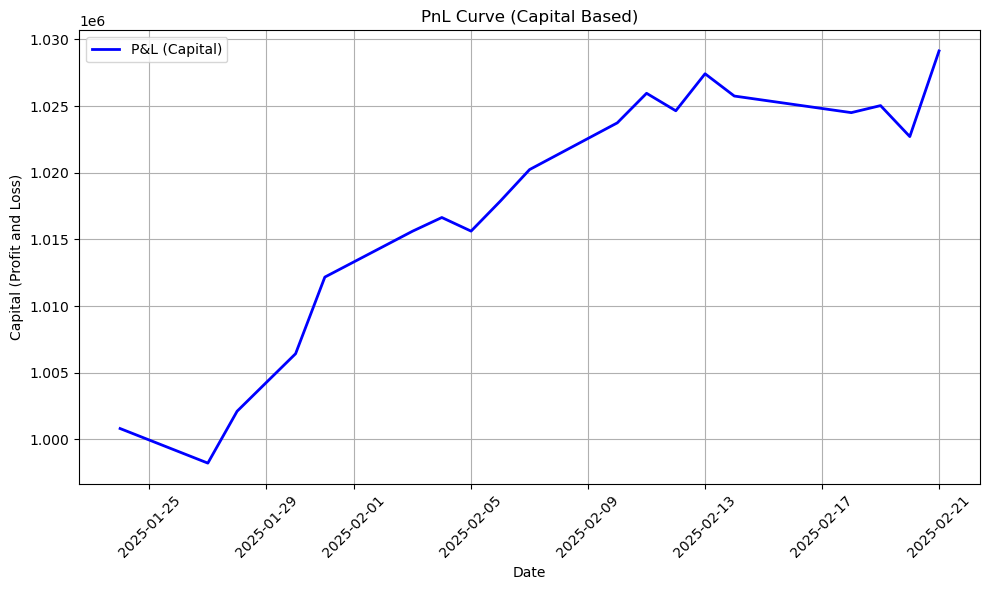

In [4]:
ba.plot_pnl()

In [5]:
import numpy as np

def calculate_sharpe_ratio(self, risk_free_rate=0.035):
    """
    计算年化夏普比率，检查波动性，并返回正的夏普比率。
    """
    df = pd.DataFrame(self.pm.trade_log)
    df["date"] = pd.to_datetime(df["date"], errors='coerce')
    
    if df.empty or "pnl" not in df.columns:
        print("交易日志为空，无法计算夏普比率")
        return None

    df["date"] = pd.to_datetime(df["date"]).dt.date

    # 计算每日收益
    df["pnl"] = df["pnl"].fillna(0)
    df["net_pnl"] = df["pnl"] - df["commission"]
    daily_pnl = df.groupby("date")["net_pnl"].sum()

    # 计算收益率
    daily_returns = daily_pnl / daily_pnl.shift(1)  # 超额收益
    daily_returns = daily_returns.dropna()  # 删除缺失值

    # 计算平均收益和波动率
    avg_daily_return = daily_returns.mean()
    daily_volatility = daily_returns.std()

    if daily_volatility == 0:
        return None  # 如果波动率为0，无法计算夏普比率

    # 计算年化夏普比率
    annualized_return = avg_daily_return * 252  # 假设252个交易日
    annualized_volatility = daily_volatility * np.sqrt(252)  # 年化波动率

    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
    return sharpe_ratio
calculate_sharpe_ratio(ba)

np.float64(-4.517866949467511)

In [6]:
def sharp_ratio(self):
    df = pd.DataFrame(self.daily_net_liquidation)
    returns = np.log(df['net_liquidation']).diff()
    returns = returns.dropna()
    
    volatility = returns.std() * np.sqrt(252) 
    print(volatility)
    return ((returns.mean()*252) - 0.035) / volatility
    
sharp_ratio(ba)

0.03953980072049499


np.float64(7.6599062025258355)